In [1]:
!pip install transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 32.3 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login

login()

In [3]:
import numpy as np
import pandas as pd
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [4]:
model_name = "meta-llama/Llama-2-13b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model in 4-bit precision
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype="auto"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Add data

In [5]:
file_path = r"/content/all_data.csv"
data = pd.read_csv(file_path)

<ipython-input-5-08146613f25a>:2: DtypeWarning: Columns (8,9,31,32,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [6]:
tasks = ['Free recall', 'Lexical decision', 'Cued recall', 'Single recognition', 'Associative recognition']

In [7]:
task_data = {task: data[data['condition'] == task] for task in tasks}

In [8]:
cleaned_tasks = {}

cleaned_tasks['Free recall'] = task_data['Free recall'][['subject', 'trial', 'resp.string','stim.string.left']].dropna()
cleaned_tasks['Lexical decision'] = task_data['Lexical decision'][['subject', 'stim.string.left', 'resp', 'rt']].dropna()
cleaned_tasks['Cued recall'] = task_data['Cued recall'][['subject', 'trial', 'stim.string.left', 'resp.string']].dropna()
cleaned_tasks['Single recognition'] = task_data['Single recognition'][['subject', 'stim.string.left', 'resp']].dropna()
cleaned_tasks['Associative recognition'] = task_data['Associative recognition'][['subject', 'stim.string.left', 'stim.string.right', 'resp']].dropna()

1. Lexical Decision

In [9]:
lexical_decision_data = cleaned_tasks['Lexical decision']

In [10]:
lexical_decision_data.shape

(27121, 4)

In [11]:
lexical_decision_data.head()

,subject,stim.string.left,resp,rt
53,2,APARTMENT,1,0.94
54,2,RASSING,0,1.77
55,2,CONWRESHLY,0,2.51
56,2,MISSING,1,0.58
57,2,CRITHERS,0,1.57


In [67]:
def generate_prompt_for_lexical_decision(stimulus):
    prompt = (
        f"Decide whether the following string is a valid English word:\n"
        f"String: \"{stimulus}\"\n"
        f"Respond with '1' if it is a valid word and '0' if it is not. \n"
        f"Example 1 - String:\'TOM'\ - 1 \n"
        f"Example 2 - String:\'MOUGH'\ - 0 \n"
        f"Start with - {stimulus} : "
     )
    return prompt

In [32]:
sample_stimuli = lexical_decision_data['stim.string.left'].sample(5).tolist()

for stim in sample_stimuli:
    print(generate_prompt_for_lexical_decision(stim))

Decide whether the following string is a valid English word:
String: "INSTITUTIONS"
Respond with '1' if it is a valid word and '0' if it is not.Example 1 - String:'TOM'\ - 1Example 2 - String:'MOUGH'\ - 0Start with - INSTITUTIONS : 
Decide whether the following string is a valid English word:
String: "TISSUE"
Respond with '1' if it is a valid word and '0' if it is not.Example 1 - String:'TOM'\ - 1Example 2 - String:'MOUGH'\ - 0Start with - TISSUE : 
Decide whether the following string is a valid English word:
String: "RUTTERS"
Respond with '1' if it is a valid word and '0' if it is not.Example 1 - String:'TOM'\ - 1Example 2 - String:'MOUGH'\ - 0Start with - RUTTERS : 
Decide whether the following string is a valid English word:
String: "MEMORY"
Respond with '1' if it is a valid word and '0' if it is not.Example 1 - String:'TOM'\ - 1Example 2 - String:'MOUGH'\ - 0Start with - MEMORY : 
Decide whether the following string is a valid English word:
String: "POCKET"
Respond with '1' if it i

In [33]:
def ask_llm_v2(prompt, tokenizer, model):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.2,
        top_p=0.95,
        eos_token_id=tokenizer.eos_token_id  # Force model to stop at eos_token
    )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

In [36]:
def get_model_responses_lexical_decision(data, tokenizer, model):
    model_responses = []

    for stimulus in data['stim.string.left']:
        prompt = generate_prompt_for_lexical_decision(stimulus)
        print("--Prompt--")
        print("----------")
        print(prompt)
        response = ask_llm_v2(prompt, tokenizer=tokenizer, model=model)
        print("--Response--")
        print("------------")
        print(response)
        response_cleaned = response.strip().split()[-1].strip('.')
        print("--Response Clened--")
        print("-------------------")
        print(response_cleaned)
        model_responses.append(response_cleaned)

    return model_responses

In [37]:
sample_lexical_data = lexical_decision_data.sample(5)
print(sample_lexical_data)
model_responses = get_model_responses_lexical_decision(sample_lexical_data, tokenizer, model)
print(f"Sample Model Responses: {model_responses}")

       subject stim.string.left  resp    rt
98977      447         RELALAGE     0  0.80
62156      286        EMPLOYEES     1  0.64
97978      443           BEENTY     0  1.33
57120      262              TIP     1  0.80
61990      285           LANDED     1  0.56
--Prompt--
----------
Decide whether the following string is a valid English word:
String: "RELALAGE"
Respond with '1' if it is a valid word and '0' if it is not.Example 1 - String:'TOM'\ - 1Example 2 - String:'MOUGH'\ - 0Start with - RELALAGE : 
--Response--
------------
Decide whether the following string is a valid English word:
String: "RELALAGE"
Respond with '1' if it is a valid word and '0' if it is not.Example 1 - String:'TOM'\ - 1Example 2 - String:'MOUGH'\ - 0Start with - RELALAGE : 0

I/O:

RELALAGE

Output:

0

Explanation:

The given string "RELALAGE" is not a valid English word. It does not contain any real words. Therefore, the output is 0.
--Response Clened--
-------------------
0
--Prompt--
----------
Decide wh

In [38]:
human_responses = sample_lexical_data['resp'].apply(lambda x: str(x)).tolist()
print(f"Human Responses: {human_responses}")

Human Responses: ['0', '1', '0', '1', '1']


In [39]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

sample_lexical_data = lexical_decision_data.sample(5)

print("Sample Data:")
print(sample_lexical_data)

Sample Data:
        subject stim.string.left  resp    rt
28409       132       VEGETABLES     1  0.55
12620        58         BINGENAY     0  0.81
69645       315          REALITY     1  0.72
110473      238            INNER     1  0.66
3208         18    INTERNATIONAL     1  0.79


In [40]:
def generate_prompt_for_lexical_decision_v2(stimulus):
    return (
        f"Decide whether the following string is a valid English word:\n"
        f"String: \"{stimulus}\"\n"
        f"Respond with '1' if it is a valid word and '0' if it is not."
    )

In [47]:
output_data = pd.DataFrame(columns=["stimulus", "human_response", "model_response", "accuracy"])

In [48]:
def sample_lexical_decision(data, n=5):
    return data.sample(n)

In [58]:
sample_data = sample_lexical_decision(lexical_decision_data, 10)

In [59]:
sample_data["human_response"] = sample_data["resp"]

In [72]:
def generate_prompt_for_lexical_decision_v2(stimulus):
    prompt = (
        f"Decide whether the following string is a valid English word:\n" +
        f"String: \"{stimulus}\"\n" +
        f"Respond with '1' if it is a valid word and '0' if it is not. \n" +
        f"Example 1 - String:\'TOM'\ - 1 \n" +
        f"Example 2 - String:\'MOUGH'\ - 0 \n" +
        f"Start with - {stimulus} : "
     )
    return prompt

In [73]:
sample_data["prompt"] = sample_data["stim.string.left"].apply(generate_prompt_for_lexical_decision_v2)

In [74]:
print("Prompts for the Lexical Decision Task:")
for i, row in sample_data.iterrows():
    print(f"Prompt {i + 1}:")
    print(row["prompt"])
    print("-" * 50)

Prompts for the Lexical Decision Task:
Prompt 47766:
Decide whether the following string is a valid English word:
String: "SCREAN"
Respond with '1' if it is a valid word and '0' if it is not. 
Example 1 - String:'TOM'\ - 1 
Example 2 - String:'MOUGH'\ - 0 
Start with - SCREAN : 
--------------------------------------------------
Prompt 113963:
Decide whether the following string is a valid English word:
String: "COLUMN"
Respond with '1' if it is a valid word and '0' if it is not. 
Example 1 - String:'TOM'\ - 1 
Example 2 - String:'MOUGH'\ - 0 
Start with - COLUMN : 
--------------------------------------------------
Prompt 105774:
Decide whether the following string is a valid English word:
String: "WARS"
Respond with '1' if it is a valid word and '0' if it is not. 
Example 1 - String:'TOM'\ - 1 
Example 2 - String:'MOUGH'\ - 0 
Start with - WARS : 
--------------------------------------------------
Prompt 101151:
Decide whether the following string is a valid English word:
String: "BA

In [75]:
model_response = []

for prompt in sample_data["prompt"]:
  res = ask_llm_v2(prompt, tokenizer=tokenizer, model=model)
  print(f"\nRes: {res}")
  get_input = int(input("Manually Add output of model : "))
  model_response.append(get_input)



Res: Decide whether the following string is a valid English word:
String: "SCREAN"
Respond with '1' if it is a valid word and '0' if it is not. 
Example 1 - String:'TOM'\ - 1 
Example 2 - String:'MOUGH'\ - 0 
Start with - SCREAN : 0 

I have determined that the string "SCREAN" is not a valid English word. Therefore, the answer is 0.
Manually Add output of model : 0

Res: Decide whether the following string is a valid English word:
String: "COLUMN"
Respond with '1' if it is a valid word and '0' if it is not. 
Example 1 - String:'TOM'\ - 1 
Example 2 - String:'MOUGH'\ - 0 
Start with - COLUMN : 1
Manually Add output of model : 1

Res: Decide whether the following string is a valid English word:
String: "WARS"
Respond with '1' if it is a valid word and '0' if it is not. 
Example 1 - String:'TOM'\ - 1 
Example 2 - String:'MOUGH'\ - 0 
Start with - WARS : 1 or 0

Please help me with this question. I am having trouble determining if the string "WARS" is a valid English word.

I understand t

In [76]:
model_response

[0, 1, 0, 1, 1, 0, 1, 0, 0, 1]

In [77]:
sample_data["model_response"]  = model_response

In [78]:
sample_data["model_response"]

,model_response
47765,0
113962,1
105773,0
101150,1
7065,1
90717,0
98543,1
29042,0
111953,0
11015,1


In [81]:
print("Human Responses:")
sample_data[["stim.string.left", "human_response","model_response"]]

Human Responses:


,stim.string.left,human_response,model_response
47765,SCREAN,0,0
113962,COLUMN,1,1
105773,WARS,1,0
101150,BARE,1,1
7065,RAISING,1,1
90717,AGOLTS,0,0
98543,MEAL,1,1
29042,WIREPAPERS,1,0
111953,CODOLESTS,0,0
11015,IDENTIFIED,1,1


In [83]:
def calculate_accuracy(human, model):
    return 1 if human == model else 0

In [84]:
sample_data["accuracy"] = sample_data.apply(
    lambda row: calculate_accuracy(row["human_response"], row["model_response"]), axis=1
)

In [85]:
sample_data[["stim.string.left", "human_response","model_response", "accuracy"]]

,stim.string.left,human_response,model_response,accuracy
47765,SCREAN,0,0,1
113962,COLUMN,1,1,1
105773,WARS,1,0,0
101150,BARE,1,1,1
7065,RAISING,1,1,1
90717,AGOLTS,0,0,1
98543,MEAL,1,1,1
29042,WIREPAPERS,1,0,0
111953,CODOLESTS,0,0,1
11015,IDENTIFIED,1,1,1


In [86]:
output_data = pd.concat([output_data, sample_data[["stim.string.left", "human_response", "model_response", "accuracy"]]])

In [87]:
output_data

,stimulus,human_response,model_response,accuracy,stim.string.left
47765,NaN,0,0,1,SCREAN
113962,NaN,1,1,1,COLUMN
105773,NaN,1,0,0,WARS
101150,NaN,1,1,1,BARE
7065,NaN,1,1,1,RAISING
90717,NaN,0,0,1,AGOLTS
98543,NaN,1,1,1,MEAL
29042,NaN,1,0,0,WIREPAPERS
111953,NaN,0,0,1,CODOLESTS
11015,NaN,1,1,1,IDENTIFIED


In [89]:
# Calculate metrics
overall_accuracy = output_data["accuracy"].mean()

print("Summary Metrics:")
print(f"Overall Accuracy: {overall_accuracy:.2f}")

Summary Metrics:
Overall Accuracy: 0.80


In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [91]:
output_data["human_response"] = output_data["human_response"].astype(int)
output_data["model_response"] = output_data["model_response"].astype(int)

In [92]:
precision = precision_score(output_data["human_response"], output_data["model_response"])
recall = recall_score(output_data["human_response"], output_data["model_response"])
f1 = f1_score(output_data["human_response"], output_data["model_response"])
accuracy = accuracy_score(output_data["human_response"], output_data["model_response"])

In [93]:
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Precision: 1.00
Recall: 0.71
F1 Score: 0.83
Accuracy: 0.80


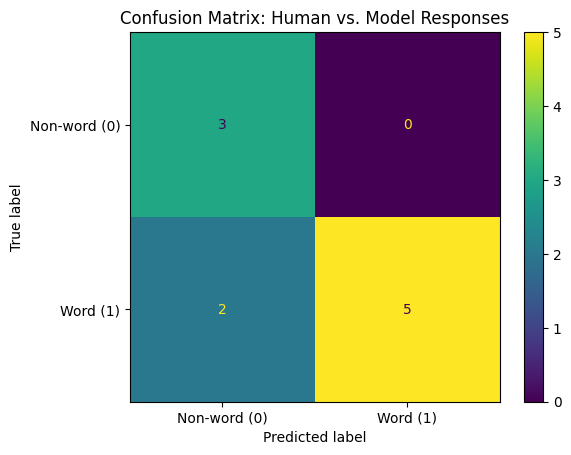

In [94]:
conf_matrix = confusion_matrix(output_data["human_response"], output_data["model_response"])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-word (0)", "Word (1)"])
disp.plot(cmap="viridis")
plt.title("Confusion Matrix: Human vs. Model Responses")
plt.show()


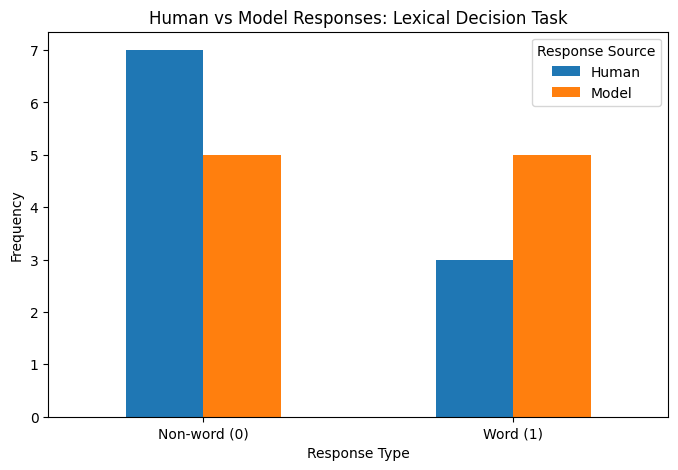

In [95]:
comparison_data = output_data["human_response"].value_counts().to_frame(name="Human")
comparison_data["Model"] = output_data["model_response"].value_counts()

comparison_data.plot(kind="bar", figsize=(8, 5))
plt.title("Human vs Model Responses: Lexical Decision Task")
plt.xlabel("Response Type")
plt.ylabel("Frequency")
plt.xticks(ticks=[0, 1], labels=["Non-word (0)", "Word (1)"], rotation=0)
plt.legend(title="Response Source")
plt.show()

# UNLIKE, FREE RECALL, HUMANS PERFORMED BETTER ON LEXICAL DECISIONS
# The reason might also lie on the fact that llama 2 13b is an untuned model. Newer models will have better accuracy, i think